In [1]:
import h5py
import numpy as np
from matplotlib import pyplot as plt
import bdpy

In [2]:
train_bdata = bdpy.BData('../../fMRI data/sub-01_perceptionNaturalImageTraining_original_VC.h5')
test_bdata = bdpy.BData('../../fMRI data/sub-01_perceptionNaturalImageTest_original_VC.h5')
# train_data.show_metadata()

train_data = train_bdata.select("ROI_VC")
test_data = test_bdata.select("ROI_VC")

num_train_samples, embedding_size = train_data.shape
num_test_samples, _ = test_data.shape

print(num_train_samples, embedding_size)
print(num_test_samples, embedding_size)

6000 11726
1200 11726


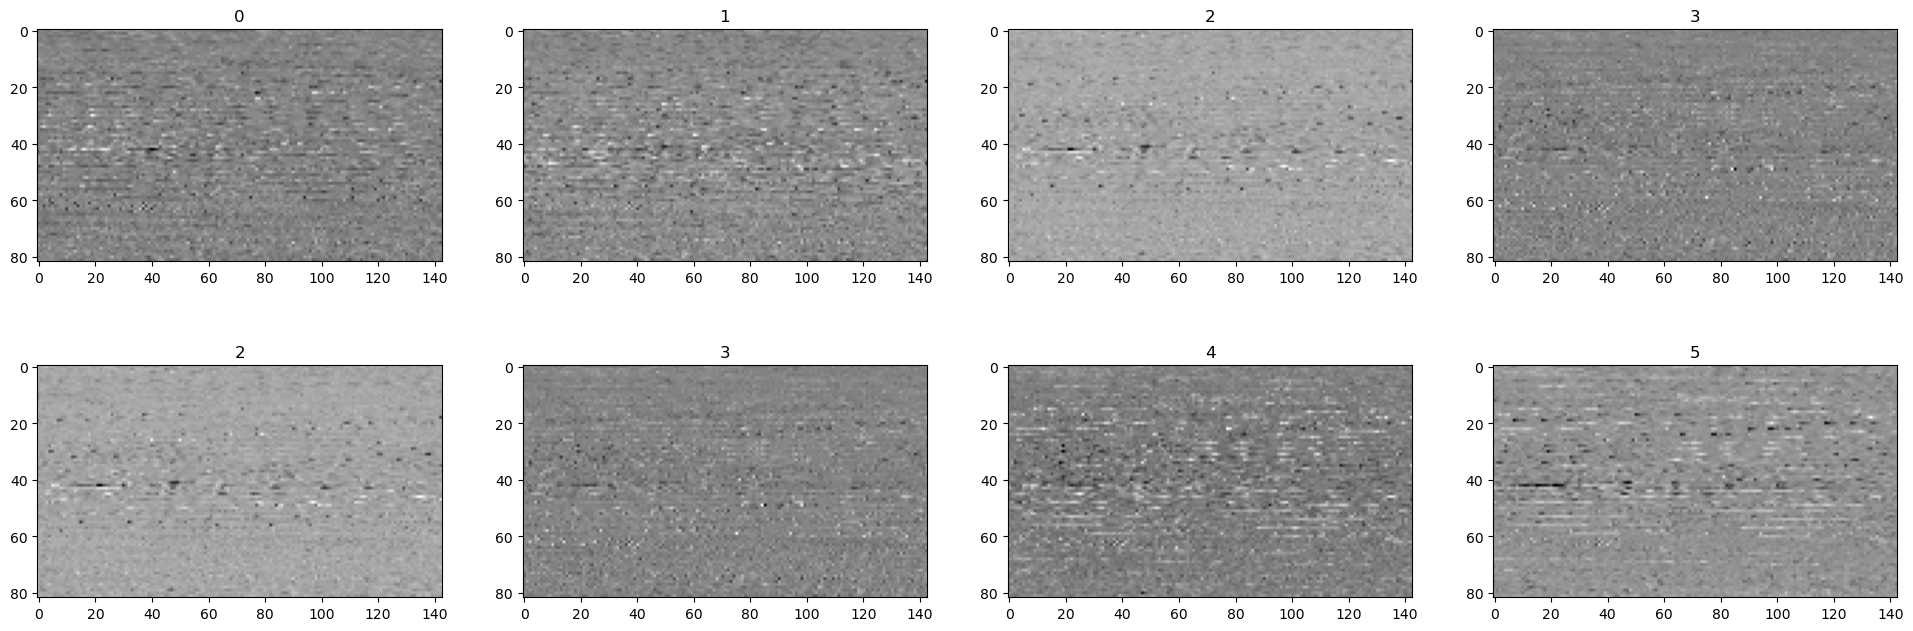

In [3]:
train_samples = np.reshape(train_data, (num_train_samples, 82, 143))

dmean = np.mean(train_samples)
dmin, dmax = np.min(train_samples), np.max(train_samples)
dscale = abs(dmax-dmin)

train_samples = train_samples / (2*dscale) + 0.5

rows = 2
fig, ax = plt.subplots(nrows=rows, ncols=4)
for r in range(rows):
    for c in range(4):
        sample_img = train_samples[2*r + c]
        ax[r][c].imshow(sample_img, cmap="gray")
        ax[r][c].set_title(f'{2*r+c}')

fig.set_size_inches(24, 4*rows)

plt.show()

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import *
latent_dim = 1024

encoder = tf.keras.Sequential([
    Input((11726, 1)),
    Conv1D(64, 3),
    Conv1D(64, 3),
    MaxPool1D(2),
    Conv1D(128, 3),
    Conv1D(128, 3),
    MaxPool1D(2),
    Conv1D(256, 3),
    Conv1D(256, 3),
    MaxPool1D(2),
    Conv1D(512, 3),
    Conv1D(512, 3),
    Conv1D(512, 3),
    MaxPool1D(2),
    Conv1D(512, 3),
    Conv1D(512, 3),
    Conv1D(512, 3),
    MaxPool1D(3),
    Conv1D(512, 3),
    Conv1D(512, 3),
    Conv1D(512, 3),
    MaxPool1D(3),
    Conv1D(512, 3),
    Conv1D(512, 3),
    Conv1D(512, 3),
    MaxPool1D(3),
    Flatten(),
    Dense(latent_dim * 2)
], name = "encoder")

# encoder.summary()

In [6]:
decoder = tf.keras.Sequential([
    Input((latent_dim)),
    Dense(24 * 512),
    Reshape((24, 512)),
    UpSampling1D(3),
    Conv1DTranspose(512, 3),
    Conv1DTranspose(512, 3),
    Conv1DTranspose(512, 3),
    UpSampling1D(3),
    Conv1DTranspose(512, 3),
    Conv1DTranspose(512, 3),
    Conv1DTranspose(512, 3),
    UpSampling1D(3),
    Conv1DTranspose(512, 3),
    Conv1DTranspose(512, 3),
    Conv1DTranspose(512, 3),
    Conv1DTranspose(512, 3),
    UpSampling1D(2),
    Conv1DTranspose(512, 3),
    Conv1DTranspose(512, 3),
    Conv1DTranspose(512, 3),
    UpSampling1D(2),
    Conv1DTranspose(256, 3),
    Conv1DTranspose(256, 3),
    UpSampling1D(2),
    Conv1DTranspose(128, 3),
    Conv1DTranspose(128, 3),
    UpSampling1D(2),
    Conv1DTranspose(64, 3),
    Conv1DTranspose(64, 3),
    Conv1DTranspose(1, 3),
    
], name = "decoder")

# decoder.summary()

In [7]:
from autoencoder import VAE

vae = VAE(encoder, decoder)
vae.build((num_train_samples, embedding_size, 1))
vae.summary()

Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (None, 2048)              34600000  
_________________________________________________________________
decoder (Sequential)         (None, 11726, 1)          23600705  
Total params: 58,200,711
Trainable params: 58,200,705
Non-trainable params: 6
_________________________________________________________________


In [8]:
vae.compile(optimizer=tf.keras.optimizers.Adam())

X0 = tf.expand_dims(train_data, -1)

vae.fit(X0, epochs=1, batch_size=128)

2022-12-05 03:18:21.610540: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-12-05 03:18:21.610732: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
